In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

!pip install lightgbm
import lightgbm as lgb


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
train_df.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [4]:
train_df.shape

(630000, 15)

In [5]:
test_df = pd.read_csv('test.csv')

In [6]:
train_df["Heart Disease"] = train_df["Heart Disease"].map({"Absence": 0 , "Presence": 1})

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Hear

In [8]:
train_df = train_df.drop(columns=["id"])

In [9]:
#Checking if the target data is imbalanced
train_df['Heart Disease'].value_counts(normalize=True)*100

Heart Disease
0    55.166032
1    44.833968
Name: proportion, dtype: float64

<Axes: >

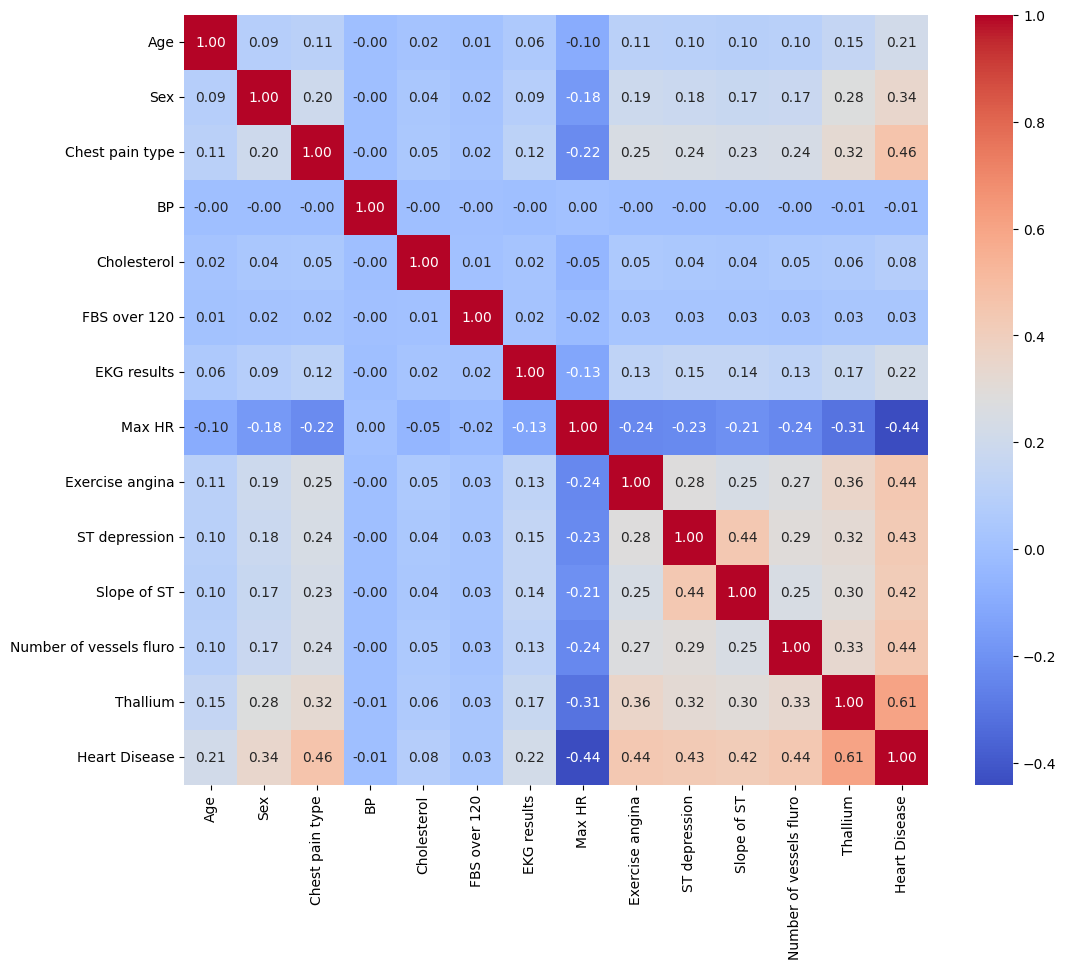

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(numeric_only=True),cmap="coolwarm",annot = True,fmt=".2f")

In [11]:
X = train_df.drop('Heart Disease',axis=1)
y = train_df['Heart Disease']

In [12]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [13]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

preds =model.predict(X_val)
probs = model.predict_proba(X_val)[:,1]

print("Accuracy:", accuracy_score(y_val,preds))
print("ROC AUC:", roc_auc_score(y_val,probs))

Accuracy: 0.8847142857142857
ROC AUC: 0.9515487462351201


In [14]:
num_cols = ["Age", "BP", "Cholesterol", "Max HR", "ST depression"]

preprocessor = ColumnTransformer(transformers=[("num",StandardScaler(),num_cols)],remainder='passthrough')
pipeline = Pipeline([("preprocessing", preprocessor),("model", LogisticRegression(max_iter=1000))])
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_val)
probs = pipeline.predict_proba(X_val)[:,1]

print("Accuracy:", accuracy_score(y_val,preds))
print("ROC AUC:", roc_auc_score(y_val,probs))

Accuracy: 0.8846428571428572
ROC AUC: 0.9515474084477311


In [15]:
rf = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)
rf.fit(X_train, y_train)
preds = rf.predict(X_val)
probs = rf.predict_proba(X_val)[:,1]

print("Accuracy:", accuracy_score(y_val,preds))
print("ROC AUC:", roc_auc_score(y_val,probs))

Accuracy: 0.8811111111111111
ROC AUC: 0.9474936131660338


In [16]:
lgb_model = lgb.LGBMClassifier(n_estimators=200,learning_rate=0.1,random_state=42)
lgb_model.fit(X_train, y_train)
preds = lgb_model.predict(X_val)
probs = lgb_model.predict_proba(X_val)[:,1]

print("Accuracy:", accuracy_score(y_val, preds))
print("ROC AUC:", roc_auc_score(y_val, probs))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225963, number of negative: 278037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448339 -> initscore=-0.207383
[LightGBM] [Info] Start training from score -0.207383
Accuracy: 0.8895952380952381
ROC AUC: 0.9558945256476622


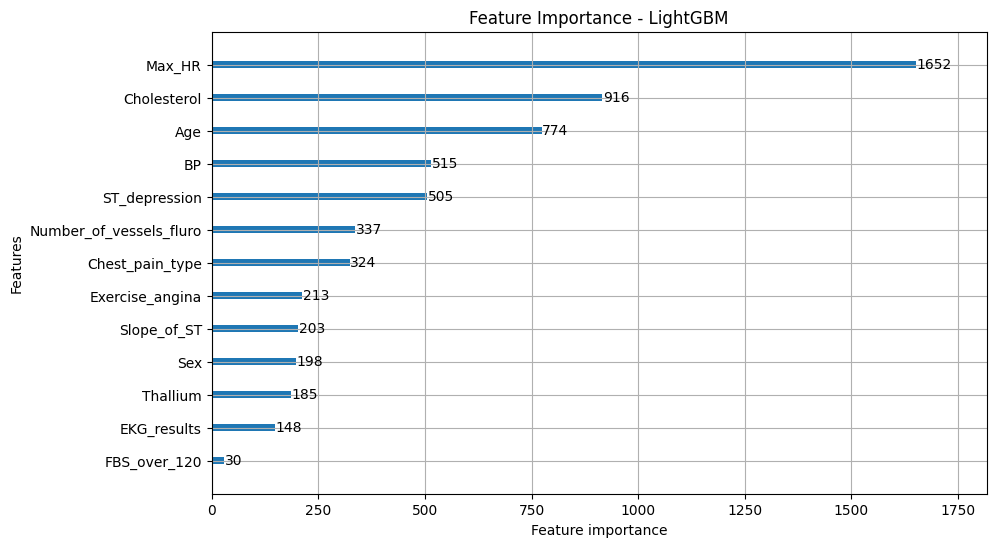

In [17]:
lgb.plot_importance(lgb_model, figsize=(10,6))
plt.title("Feature Importance - LightGBM")
plt.show()

In [18]:
train_probs = lgb_model.predict_proba(X_train)[:,1]
print("Train AUC:", roc_auc_score(y_train, train_probs))

Train AUC: 0.956794585051783


In [19]:
cv_auc = cross_val_score(
    lgb_model,
    X,
    y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

print("CV AUC:", cv_auc.mean())

CV AUC: 0.9551026678684286


In [20]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb_model.fit(X_train, y_train)
preds = lgb_model.predict(X_val)
probs = lgb_model.predict_proba(X_val)[:,1]

print("Accuracy:", accuracy_score(y_val, preds))
print("ROC AUC:", roc_auc_score(y_val, probs))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225963, number of negative: 278037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448339 -> initscore=-0.207383
[LightGBM] [Info] Start training from score -0.207383
Accuracy: 0.8898730158730159
ROC AUC: 0.956057789444718


In [21]:
test_features = test_df[X.columns]
test_probs = model.predict_proba(test_features)[:, 1]

submission = pd.DataFrame({
    "id": test_df["id"],
    "Heart Disease": test_probs
})

# Save file
submission.to_csv("submission_5_2.csv", index=False)